In [2]:
from collections import defaultdict
import math
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import pandas as pd

In [2]:
df = pd.read_csv("C:\\Users\\SHANMUGAPRIYAA\\OneDrive\\Documents\\drugsComTest_raw.csv")
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [3]:
df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 6 else 0)

In [4]:
df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22,1
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17,1
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3,1
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35,1
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4,1


In [5]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


1    41928
0    11838
Name: sentiment, dtype: int64


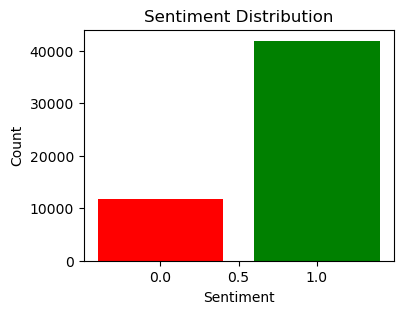

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
colors = ['green', 'red', 'blue'] 
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


# Bernoullis naive bayes classifier

In [7]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

In [8]:
# Create the vocabulary
vocabulary = set()
for review in X_train:
    vocabulary.update(set(review.split()))

In [9]:
# Convert sentiment labels to numeric values
y_train_numeric = y_train.replace({'positive': 1, 'negative': 0})


In [10]:
# Calculate the prior probabilities
prior_positive = y_train_numeric.mean()
prior_negative = 1 - prior_positive

In [11]:
# Initialize the count dictionaries
positive_counts = {word: 0 for word in vocabulary}
negative_counts = {word: 0 for word in vocabulary}

In [12]:
# Count the occurrences of words in positive and negative reviews
for review, sentiment in zip(X_train, y_train):
    words = set(review.split())
    if sentiment == 1:
        for word in words:
            positive_counts[word] += 1
    else:
        for word in words:
            negative_counts[word] += 1

In [13]:
# Calculate the likelihood probabilities
likelihood_positive = {}
likelihood_negative = {}
smoothing = 1e-6
for word in vocabulary:
    likelihood_positive[word] = (positive_counts[word] + smoothing) / (y_train.sum() + 2 * smoothing)
    likelihood_negative[word] = (negative_counts[word] + smoothing) / ((y_train.size - y_train.sum()) + 2 * smoothing)

In [14]:
import numpy as np
# Predict the sentiments of test reviews
y_pred = []
for review in X_test:
    words = set(review.split())
    log_prob_positive = np.log(prior_positive)
    log_prob_negative = np.log(prior_negative)
    
    for word in words:
        if word in vocabulary:
            log_prob_positive += np.log(likelihood_positive[word])
            log_prob_negative += np.log(likelihood_negative[word])
    
    if log_prob_positive > log_prob_negative:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [15]:
# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)

Accuracy: 0.8337362841733309


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [17]:
from sklearn.metrics import classification_report
# Print the classification report
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.38      0.50      2345
           1       0.85      0.96      0.90      8409

    accuracy                           0.83     10754
   macro avg       0.79      0.67      0.70     10754
weighted avg       0.82      0.83      0.81     10754



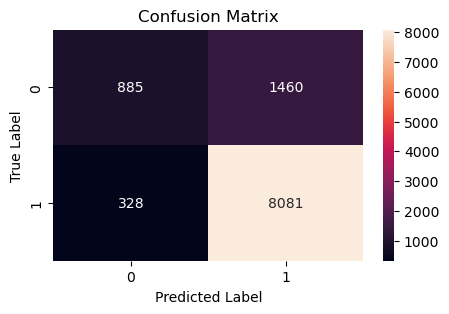

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Gaussian naive bayes classifier

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
class GaussianNaiveBayes:
    def __init__(self):
        self.class_priors = {}
        self.mean = {}
        self.variance = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_counts = {}
        self.mean = {}
        self.variance = {}

        for c in self.classes:
            X_c = X[y == c]
            self.class_counts[c] = len(X_c)
            self.class_priors[c] = len(X_c) / len(X)
            self.mean[c] = np.mean(X_c, axis=0)
            self.variance[c] = np.var(X_c, axis=0)

    def _calculate_likelihood(self, x, mean, variance):
        exponent = np.exp(-((x - mean) ** 2) / (2 * variance))
        return (1 / np.sqrt(2 * np.pi * variance)) * exponent

    def predict(self, X):
        y_pred = []

        for x in X:
            class_scores = []

            for c in self.classes:
                class_prior = self.class_priors[c]
                class_mean = self.mean[c]
                class_variance = self.variance[c]

                likelihoods = self._calculate_likelihood(x, class_mean, class_variance)
                class_score = np.prod(likelihoods) * class_prior
                class_scores.append(class_score)

            predicted_class = self.classes[np.argmax(class_scores)]
            y_pred.append(predicted_class)

        return y_pred

In [21]:
# Preprocess the data
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 6 else 'negative')

In [22]:
# Split the dataset into training and testing sets
X = df['review'].values
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Create a CountVectorizer to convert text into numerical features
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [24]:
# Initialize and fit the Gaussian Naive Bayes classifier
nb_classifier = GaussianNaiveBayes()
nb_classifier.fit(X_train_counts.toarray(), y_train)

In [46]:
zero_indices = np.where(X_test_counts.toarray() == 0)
if zero_indices:
    print("Zero values found in X_test_counts at indices:", zero_indices)
X_test_counts_nonzero = X_test_counts.toarray()
X_test_counts_nonzero[X_test_counts_nonzero == 0] = 1e-10
y_pred = []
for x in X_test_counts_nonzero:
    probabilities = []
    for c in nb_classifier.classes:
        class_prior = nb_classifier.class_priors.get(c, 0)  # Use 0 as default prior for missing classes
        if c in nb_classifier.feature_probabilities:
            likelihood = np.sum(x * np.log(nb_classifier.feature_probabilities[c]))
        else:
            likelihood = 0  
        class_score = np.log(class_prior) + likelihood
        probabilities.append(class_score)
    predicted_class = nb_classifier.classes[np.argmax(probabilities)]
    y_pred.append(predicted_class)
y_pred = np.array(y_pred)

Zero values found in X_test_counts at indices: (array([    0,     0,     0, ..., 10753, 10753, 10753], dtype=int64), array([    0,     1,     2, ..., 30820, 30821, 30822], dtype=int64))


C:\Users\SHANMUGAPRIYAA\AppData\Local\Temp\ipykernel_3192\1662533359.py:26: RuntimeWarning: divide by zero encountered in log
  class_score = np.log(class_prior) + likelihood


In [47]:
# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)

Accuracy: 0.30249209596429233


In [58]:
from sklearn.metrics import classification_report
# Print the classification report
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

    negative       0.30      1.00      0.46      3253
    positive       0.00      0.00      0.00      7501

    accuracy                           0.30     10754
   macro avg       0.15      0.50      0.23     10754
weighted avg       0.09      0.30      0.14     10754



C:\Users\SHANMUGAPRIYAA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SHANMUGAPRIYAA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SHANMUGAPRIYAA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


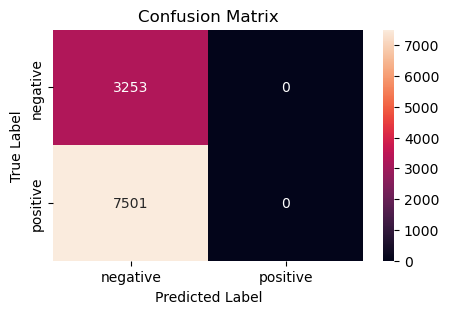

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Multinomial naive bayes classifier¶

In [18]:
import pandas as pd
import numpy as np

class MultinomialNaiveBayes:
    def __init__(self):
        self.classes = None
        self.class_counts = {}
        self.feature_counts = {}
        self.feature_probabilities = {}
        self.class_priors = {}
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_counts = {}
        self.feature_counts = {}
        self.feature_probabilities = {}
        self.class_priors = {}
        # Count the occurrences of each class and each feature
        for c in self.classes:
            self.class_counts[c] = 0
            self.feature_counts[c] = np.zeros(X.shape[1])
        # Update the class counts and feature counts
        for x, c in zip(X, y):
            self.class_counts[c] += 1
            self.feature_counts[c] += x
        # Calculate class priors
        num_samples = len(y)
        for c in self.classes:
            self.class_priors[c] = self.class_counts[c] / num_samples
        # Calculate feature probabilities
        for c in self.classes:
            total_count = np.sum(self.feature_counts[c])
            self.feature_probabilities[c] = (self.feature_counts[c] + 1) / (total_count + X.shape[1])
    def _calculate_likelihood(self, x, class_label):
        likelihood = np.sum(x * np.log(self.feature_probabilities[class_label]))
        return likelihood
    def predict(self, X):
        y_pred = []
        for x in X:
            class_scores = []
            for c in self.classes:
                class_prior = self.class_priors[c]
                likelihood = self._calculate_likelihood(x, c)
                class_score = np.log(class_prior) + likelihood
                class_scores.append(class_score)
            predicted_class = self.classes[np.argmax(class_scores)]
            y_pred.append(predicted_class)
        return y_pred

In [19]:
# Preprocess the data
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 6 else 'negative')

In [20]:
# Convert text reviews to numerical features
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(X)

In [21]:
# Initialize and fit the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNaiveBayes()
nb_classifier.fit(X_train, y_train)

In [22]:
# Predict the sentiments of test reviews
y_pred = nb_classifier.predict(X_test)

In [23]:
# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8022131299981402


In [24]:
from sklearn.metrics import classification_report
# Print the classification report
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.66      0.67      3253
    positive       0.86      0.86      0.86      7501

    accuracy                           0.80     10754
   macro avg       0.77      0.76      0.76     10754
weighted avg       0.80      0.80      0.80     10754



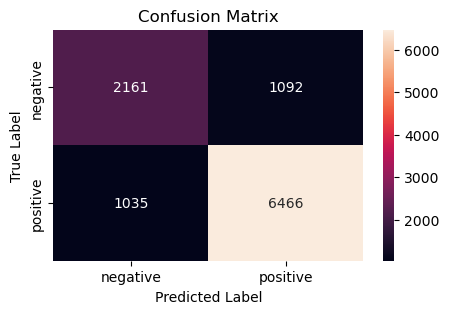

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
def map_condition_drug(df):
    condition_drug_map = {}
    for index, row in df.iterrows():
        condition = row['condition']
        drug_name = row['drugName']
        if condition not in condition_drug_map:
            condition_drug_map[condition] = set()
        condition_drug_map[condition].add(drug_name)
    return condition_drug_map

In [27]:
condition_drug_mapping = map_condition_drug(df)
# Prompt the user to enter a condition
condition_input = input("Enter a condition: ")
# Get the corresponding drug names for the input condition
if condition_input in condition_drug_mapping:
    drug_names = condition_drug_mapping[condition_input]
    print(f"Condition: {condition_input}")
    print(f"Drug Names: {', '.join(drug_names)}")
else:
    print("No drug names found for the input condition.")

Enter a condition: Pain
Condition: Pain
Drug Names: Acetaminophen / aspirin / caffeine / salicylamide, Toradol IV / IM, Talwin Nx, Hydromorphone, Acetaminophen / hydrocodone, Anacin, Pamelor, Atarax, Choline salicylate / magnesium salicylate, Hysingla ER, Stadol, Nubain, Celebrex, Opana ER, Orudis KT, Morphine, Children's Motrin, Ketorolac, Etodolac, Cataflam, Hydrocodone / ibuprofen, Percocet, Vicodin, Nucynta ER, Dilaudid, Levo-Dromoran, Percodan, Methadose, Pramoxine, Celecoxib, Oxycodone, Motrin, Dolophine, Fentanyl, Acetaminophen / oxycodone, Capzasin, Motrin IB, Tramadol, Cymbalta, Oxydose, Aspirin / caffeine, Acetaminophen / phenyltoloxamine, Lidocaine Viscous, Butrans, Exparel, Diphenhydramine / naproxen, Buprenorphine, Acetaminophen / caffeine / dihydrocodeine, Vicoprofen, Neurontin, Capsaicin, Myophen, Fiorinal, Levorphanol, Ultracet, Fentora, Trezix, Acetaminophen / tramadol, Zorvolex, Indomethacin, Propoxyphene, Morphine / naltrexone, Acetaminophen / diphenhydramine, Tyleno